In [53]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

In [55]:
# read new images

data = pd.read_csv('data/new_data/new_log.csv',
                   dtype={'center': str,'steering': np.float32},
                   skipinitialspace=1)
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))


center       object
steering    float32
dtype: object
Training data size =  13505
Training labels size =  13505


In [56]:
data.head()

,center,steering
0,IMG/image_0.jpg,0.217953
1,IMG/image_1.jpg,0.247953
2,IMG/image_2.jpg,0.457953
3,IMG/image_3.jpg,-0.517953
4,IMG/image_4.jpg,-0.487953


In [57]:
X_train.head()

0    IMG/image_0.jpg
1    IMG/image_1.jpg
2    IMG/image_2.jpg
3    IMG/image_3.jpg
4    IMG/image_4.jpg
Name: center, dtype: object

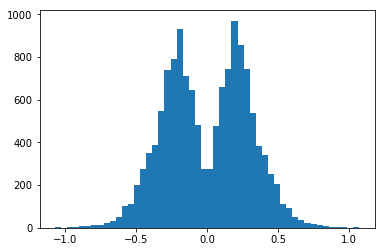

X_train: 13505
y_train: 13505


In [58]:
# examine the data
import matplotlib.pyplot as plt
plt.hist(y_train,50)
plt.show()
data = list(X_train)
labels = list(y_train)
print('X_train:',len(X_train))
print('y_train:',len(y_train))

In [59]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2,random_state=42)
#print(X_train.shape[0])
print('Data splitted into train, validation anda test data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))
print('Test data size = ',len(X_test))
print('Test labels size = ',len(y_test))

Data splitted into train, validation anda test data
Training data size =  9453
Training labels size =  9453
Validation data size =  3241
Validation labels size =  3241
Test data size =  811
Test labels size =  811


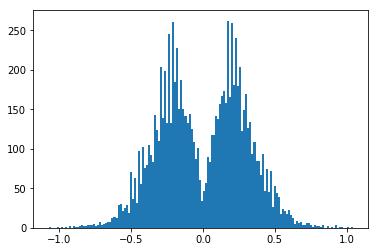

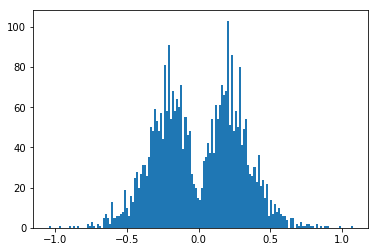

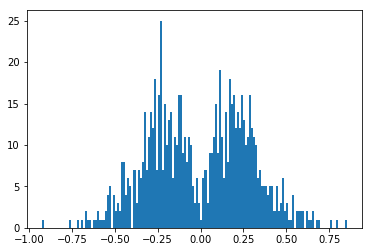

In [60]:
plt.hist(y_train,150)
plt.show()
plt.hist(y_val,150)
plt.show()
plt.hist(y_test,150)
plt.show()

In [61]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization



# define the model
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(80, 300, 3),output_shape=(80, 300, 3)))
model.add(Conv2D(24, (5, 5),strides=(2, 2),kernel_regularizer='l2',dim_ordering='tf'))
model.add(Activation('relu'))
model.add(Conv2D(36, (5, 5),strides=(2, 2),kernel_regularizer='l2',dim_ordering='tf'))
model.add(Activation('relu'))
model.add(Conv2D(48, (5, 5),strides=(2, 2),kernel_regularizer='l2',dim_ordering='tf'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),strides=(1, 1),kernel_regularizer='l2',dim_ordering='tf'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),strides=(1, 1),kernel_regularizer='l2',dim_ordering='tf'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100, name='fc1'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(50, name='fc2'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, name='fc3'))
model.add(Activation('relu'))
model.add(Dense(1,name='output'))

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
model.summary()
print('Model defined')

/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), kernel_regularizer="l2", data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), kernel_regularizer="l2", data_format="channels_last")`
  del sys.path[0]
/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), kernel_regularizer="l2", data_format="channels_last")`
  from ipykernel import kernelapp as app
/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), kernel_regularizer="l2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 80, 300, 3)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 38, 148, 24)       1824      
_________________________________________________________________
activation_71 (Activation)   (None, 38, 148, 24)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 17, 72, 36)        21636     
_________________________________________________________________
activation_72 (Activation)   (None, 17, 72, 36)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 34, 48)         43248     
_________________________________________________________________
activation_73 (Activation)   (None, 7, 34, 48)         0         
__________

In [62]:
from PIL import Image
    
def generator(X, Y):
    while 1:
        for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.reshape(angle, [1])
            image = Image.open('./data/new_data/' + path)
            image_array = np.asarray(image)
            transformed_image_array = image_array[None, :, :, :]
            yield transformed_image_array, angle

IMG/image_6973.jpg


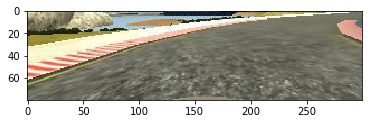

In [63]:
# image example from dataset
print(X_train[0])
image = Image.open('./data/new_data/' + X_train[0])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()

In [64]:
#train the model
from keras.callbacks import ModelCheckpoint
print('')
iterations = 30
train_batch_size = 100
val_batch_size = 100

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor = 'val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator(X_train, y_train), 
                    samples_per_epoch= train_batch_size,
                    nb_epoch=iterations,
                    callbacks=callbacks_list,
                    verbose=1,
                    validation_data=generator(X_val, y_val),
                    nb_val_samples=val_batch_size)

print('----------------- Model trained! -----------------')

/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/vmueller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., steps_per_epoch=100, epochs=30, validation_steps=100)`


Epoch 1/30
100/100 [==============================] - 5s - loss: 1.7013 - val_loss: 1.4076
Epoch 2/30
100/100 [==============================] - 5s - loss: 1.2251 - val_loss: 1.0263
Epoch 3/30
100/100 [==============================] - 4s - loss: 0.8898 - val_loss: 0.7361
Epoch 4/30
100/100 [==============================] - 4s - loss: 0.6406 - val_loss: 0.5570
Epoch 5/30
100/100 [==============================] - 4s - loss: 0.5021 - val_loss: 0.4346
Epoch 6/30
100/100 [==============================] - 4s - loss: 0.4010 - val_loss: 0.3467
Epoch 7/30
100/100 [==============================] - 4s - loss: 0.2993 - val_loss: 0.2816
Epoch 8/30
100/100 [==============================] - 4s - loss: 0.2659 - val_loss: 0.2387
Epoch 9/30
100/100 [==============================] - 3s - loss: 0.2027 - val_loss: 0.1856
Epoch 10/30
100/100 [==============================] - 4s - loss: 0.1769 - val_loss: 0.1569
Epoch 11/30
100/100 [==============================] - 4s - loss: 0.1785 - val_loss: 0.15

In [73]:
model.save('model.h5')